<a href="https://colab.research.google.com/github/kimdesok/Machine-Learning-Engineering-for-Production-MLOps/blob/main/c4-wk1-Tensorflow-serving-in-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [3]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
TensorFlow version: 2.6.0


## Import Mnist dataset



In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images / 255.0
test_images = test_images / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
# Reshape the arrays below.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape,
train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


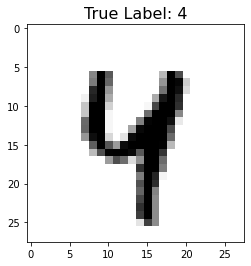

In [7]:
idx = 42
plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

In [8]:
# Create a model.
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3,
  strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Configure the model for training.
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
epochs = 5
# Train the model.
history = model.fit(train_images, train_labels, epochs=epochs)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3691 - accuracy: 0.8980
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1904 - accuracy: 0.9442
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1498 - accuracy: 0.9563
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1287 - accuracy: 0.9616
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1160 - accuracy: 0.9653


In [10]:
# Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels, verbose=0)
for metric, value in zip(model.metrics_names, results_eval):
  print(metric + ': {:.3}'.format(value))

loss: 0.116
accuracy: 0.966


In [11]:
import tempfile
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)
print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 92
drwxr-xr-x 2 root root  4096 Nov  2 10:26 assets
-rw-r--r-- 1 root root  8081 Nov  2 10:26 keras_metadata.pb
-rw-r--r-- 1 root root 75689 Nov  2 10:26 saved_model.pb
drwxr-xr-x 2 root root  4096 Nov  2 10:26 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [12]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W1102 10:27:53.778752 139784460539776 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

## Add TensorFlow Serving distribution URI as a package source:

In [13]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [14]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
OK
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:9 http://storage.googleapis.com/

##Install TensorFlow Serving

In [15]:
#!apt autoremove
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 63 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (66.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155062 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


## Start running Tensorflow Serving

In [16]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [25]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [26]:
!tail server.log

2021-11-02 10:34:41.196601: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 46151 microseconds.
2021-11-02 10:34:41.197083: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-11-02 10:34:41.197218: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: digits_model version: 1}
2021-11-02 10:34:41.197750: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-11-02 10:34:41.197794: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-11-02 10:34:41.197806: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-11-02 10:34:41.198223: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename

### Make REST requests

In [27]:
import json
data = json.dumps({"signature_name": "serving_default", "instances":test_images[0:3].tolist()})

In [28]:
# docs_infra: no_execute
!pip install -q requests

In [29]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

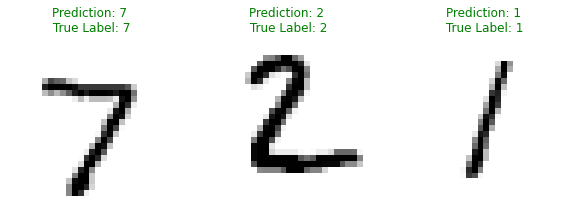

In [30]:
plt.figure(figsize=(10,15))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
  plt.axis('off')
  color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
  plt.title('Prediction: {}\n True Label: {}'.format(np.argmax(predictions[i]),
  test_labels[i]), color=color)
plt.show()